# BiblioAnalysis_OnDev

### Version: 0.0.0

### Aims
- This jupyter notebook results from the use analysis of BiblioTools2jupyter notebook and a new implementation of the following parts:
    - Parsing: replaced and tested 
    - Corpus description: replaced and tested
    - Filtering: replaced and tested, integrating the "EXCLUSION" mode and the recursive filtering
    - Cooccurrence analysis : replaced and tested, integrating graph plot and countries GPS coordinates
    - Coupling analyis : replaced and tested
    
### Created modules in the package BiblioAnalysis_Utils
    - BiblioParser.py
    - BiblioDescription.py
    - BiblioFilter.py
    - BiblioCooc.py
    - BiblioCoupling.py
    - GUI_utils.py

### BiblioTool3.2 source
http://www.sebastian-grauwin.com/bibliomaps/download.html 

### List of initial Python packages extracted from  BiblioTool3.2
- biblio_parser.py	⇒ pre-processes WOS / Scopus data files,
- corpus_description.py	⇒ performs a frequency analysis of the items in corpus,
- filter.py	⇒ filters the corpus according to a range of potential queries but still too specific
- biblio_coupling.py	⇒ performs a BC anaysis of the corpus,
- cooc_graphs.py	⇒ produces various co-occurrence graphs based on the corpus (call parameters changed)

### Specifically required list of pip install 
- !pip3 install squarify 
- !pip3 install inquirer
- !pip3 install python-louvain

### Specifically required nltk downloads
- import nltk
    - nltk.download('punkt')
    - nltk.download('averaged_perceptron_tagger')
    - nltk.download('wordnet')

## Preliminary instructions
#### These actions will be interactively performed in the next version of the Jupyter notebook
1- Create the 'BiblioAnalysis_Files/' folder in your 'Users/' folder
<br>
2- Create in this 'BiblioAnalysis_Files/' folder, the 'Configuration_Files/' folder
<br>
3- Store your configuration files (config_users.json and config_filter.json) in the 'Configuration_Files/' folder
<br>
4- Create, in the 'BiblioAnalysis_Files/' folder, your project folder with the name set in the configuration file 'config_users.json'
<br>
5- Create the 'rawdata/' folder in your project folder
<br>
6- Store your corpus file (either wos or scopus extraction) in the 'rawdata/' folder of your project folder
<br>


In [7]:
# Standard library imports
import sys
import json
from pathlib import Path

## User identification
root = Path.home()

## Building dict of paths for potential users (to be completed with the specific paths of new users) 
user = {}
if root == Path('/Users/amal'):
    user = {
        'mac_packages' : '/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages',
        'path1' : 'My_Jupyter/',
        'path2' : 'BiblioAnalysis_Files/',
        'path3' : 'Configuration_Files/'
        }

elif root == Path('C:/Users/franc'):
    user = {
        'mac_packages' : '',
        'path1' : '',
        'path2' : 'BiblioAnalysis_Files/',
        'path3' : 'Configuration_Files/'
        }
else:
    user = {
        'mac_packages' : '/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages',
        'path1' : 'GitHubClone/',
        'path2' : 'BiblioAnalysis_Files/',
        'path3' : 'Configuration_Files/'
        }    

## Add path of 'site-packages' where useful packages are stored on MAC-OS; no impact for Windows
sys.path.append(user['mac_packages'])

## Getting complementary information from user configuration file 
file_config_users = root / Path(user['path2'] + user['path3'] + 'config_users.json') 
with open(file_config_users, "r") as read_file:
    config_users = json.load(read_file)    
user_id =  config_users['users']
database_type =  config_users['database']
myprojectname = config_users['myprojectname']
expert =  config_users['expert']

## Folder containing the folder Utils
rep_utils = root / Path(user['path1'] + 'BiblioAnalysis/' + 'BiblioAnalysis_RefFiles')

## Specific files for scopus type database
scopus_cat_codes = 'scopus_cat_codes.txt'
scopus_journals_issn_cat = 'scopus_journals_issn_cat.txt'

print('Specific paths set for ' + '"' + user_id + '"')
print('User file full path: ' + str(file_config_users))
print('Database type:       ' + database_type)
print('Project name:        ' + myprojectname)

Specific paths set for "francois"
User file full path: C:\Users\franc\BiblioAnalysis_Files\Configuration_Files\config_users.json
Database type:       wos
Project name:        Test_2005/


## Data parsing
- articles.dat is the central file, listing all the publications within the corpus. It contains informations such as the document type (article, letter, review, conf proceeding, etc), title, year of publication, publication source, doi, number of citations (given by WOS or Scopus at the time of the extraction) AND a unique identifier used in all the other files to identify a precise publication.
- database.dat keeps track of the origin of the data, some part of the analysis being specific to WOS or Scopus data.
- authors.dat lists all authors names associated to all publications ID.
- addresses.dat lists all adresses associated to all publications ID, along with a specific ID for each adresse line. These adresses are reported as they appear in the raw data, without any further processing.
- countries.dat lists all countries associated to all publications ID and adresses lines ID. The countries are extracted from the adresses fields of the raw data, with some cleaning (changing mentions of US states and UK countries to respectively the USA and UK).
- institutions.dat lists all the comma-separated entities appearing in the adresses field associated to all publications ID and adresses lines ID, except those refering to a physical adresses. These entities correspond to various name variants of universities, organisms, hospitals, labs, services, departments, etc as they appear in the raw data. No treatment is made to e.g. filtering out the entities corresponding a given hierarchy level.
- keywords.dat lists various types of keywords associated to all publications ID. "AK" keywords correspond to Author's keywords. "IK" keywords correspond to either WOS or Scopus keywords, which are built based on the authors' keywords, the title and abstract. "TK" correspond to title words (from which we simply remove common words and stop words - no stemming is performed). TK are especially useful when studying pre-90's publications, when the use of keywords was not yet standard.
- references.dat lists all the references associated to all publications ID. The rawdata is parsed to store the first author name, title, source, volume and page of each reference of the raw "references" field.
- subjects.dat lists all subject categories associated to all publications ID (a journal may be associated to many subject category). WOS classifies the sources it indexes into ∼ 250 categories, that are reported in the extracted data. Scopus classifies its sources into 27 major categories and ∼ 300 sub-categories, none of which are reported in the extracted data. We use Elsevier Source Title List (october 2017 version) to retrieve that information. The "subject.dat" contains the info relative to the major categories.
- subjects2.dat lists Scopus's sub-categories, if the use database is Scopus.
- AA_log.txt keeps track of the date/time the script was executed and of all the messages displayed on the terminal (number of publications extracted, % of references rejected, etc).

In [8]:
# Standard libraries import
import os

# Local imports
import BiblioAnalysis_Utils as bau


## ##################################################
## ##################################################
## ##################################################
## Building the names of the useful folders

    # Folder containing the wos or scopus file to process
in_dir_parsing = root / Path(user['path2'] + myprojectname +'rawdata')

    # Folder containing the output files of the data parsing 
out_dir_parsing = root / Path(user['path2'] + myprojectname + 'parsing')
if not os.path.exists(out_dir_parsing):
    os.mkdir(out_dir_parsing)

## Running function biblio_parser
bau.biblio_parser(in_dir_parsing, out_dir_parsing, database_type, expert, rep_utils)

print("Corpus parsing saved in folder:", str(out_dir_parsing))

Corpus parsing saved in folder: C:\Users\franc\BiblioAnalysis_Files\Test_2005\parsing


##  Corpus description
Before doing anything else, you should get a general idea of the content of your database. Execute the following command line:

- python BiblioTools3.2/describe_corpus.py -i myprojectname/ -v <br>

The options -i indicates the data input folder and the option -v puts the verbose mode on (detailed info about the script process will be displayed in the terminal). This script performs several basic tasks:

- it performs a series of frequency analysis, computing the number of occurrences of each item (authors, keywords, references, etc) within the publications of the corpus. These frequencies are automatically stored into several "freq_xxx.dat" files within a newly created "freq" folder.
- it performs a series of generic statistical analysis, storing the numbers of distinct items of each type (e.g. there are x distinct keyword in the corpus ), the distributions of number of occurrences of each item (e.g. there are x keywords appearing in at least y publications) and the distribution of number of items per publication (e.g.there are x% of publications with y keywords). All these statistics are stored in the "DISTRIBS_itemuse.json" file.
- it also performs a co-occurrence analysis, computing the number of co-occurrence of pairs of items among the top 100 most frequent items of each type (e.g. computing how often the two most used keywords appear together in the same publications). The results of this analysis are stored in the "coocnetworks.json" file. More systematic co-occurrence analysis can also be performed with another script, cf the Co-occurrence Maps section below.
All the generated files can be opened and read with a simple text editor. The freq_xxx.dat, listing items by order of frequency, can also be read in a spreadsheet software such as excel. All the files are however primarily made to be read in the BiblioMaps interface.

In [9]:
# Local imports
import BiblioAnalysis_Utils as bau

## ##################################################
## ##################################################
## ##################################################
## Building the names of the useful folders

    # Folder containing the wos or scopus parsed files
in_dir_corpus = out_dir_parsing

    # Folder containing the wos or scopus parsed and analysed files
out_dir_corpus = root / Path(user['path2'] + myprojectname + 'freq')
if not os.path.exists(out_dir_corpus):
    os.mkdir(out_dir_corpus)

## Running describe_corpus
verbose = False
bau.describe_corpus(in_dir_corpus, out_dir_corpus, verbose)
print("Corpus description saved in folder:", str(out_dir_corpus))

## Running plot of treemap for a selected item_treemap
do_treemap = input("Treemap for an item of the corpus description? (y/n): ")
if do_treemap == 'y':
    path_treemap = user['path2'] + myprojectname + 'freq/'
    renew_treemap = 'y'
    while renew_treemap == 'y' :
        print("Choose the item for treemap in the tk window")
        item_treemap = bau.item_selection()
        file_name_treemap = root / Path(path_treemap + 'freq_'+ item_treemap +'.dat')
        print("Item selected:",item_treemap)
        bau.treemap_item(item_treemap, file_name_treemap)
        renew_treemap = input("\n\nTreemap for a new item ? (y/n): ")



Corpus description saved in folder: C:\Users\franc\BiblioAnalysis_Files\Test_2005\freq
Treemap for an item of the corpus description? (y/n): y
Choose the item for treemap in the tk window
Item selected: subjects
Enter the number of items to be used for the treemap (min = 1, max = 113): n


ValueError: invalid literal for int() with base 10: 'n'

### Filtering the data
#### To be run after corpus description to allow using the following functions : describe_corpus() , treemap_item()

If, upon exploring the nature of the data you realize that before going further you'd prefer to filter your corpus based on some characteristic (keeping only the publications from certain years, using some keywords or references, written by some authors from some countries, etc), you can filter the initial corpus thanks to the script:

- python BiblioTools3.2/filter.py -i myprojectname/ -o myprojectname_filtered -v <br>

Edit the 'filter.py' file to specify your filters. You'll also need to create a new "myprojectname_filtered" main folder before running the script.
- create the files articles.dat, addresses.dat, authors.dat, countries.dat, institutions.dat, keywords.dat, references.dat, subjects.dat, subjects2.dat

In [ ]:

# Standard library imports 
import shutil                      

# Local imports
import BiblioAnalysis_Utils as bau

## Recursive filtering

# Allows prints in filter_corpus_new function
verbose = False

# String used to set the output folder name of the subsequent filterings in the recursive_filter function
path_filter = user['path2'] + myprojectname + 'filter' 

## Building the absolute file name of filter configuration file for the user
file_config_filters = root / Path(user['path2'] + user['path3'] + 'config_filters.json')

# Initialization of parameters for recursive filtering
filtering_step = 1
while True:
    
    ## Building the names of the useful folders and creating the output folder if not find 
    if filtering_step == 1:
        in_dir_filter = out_dir_parsing
    else:
        renew_filtering = input("Apply a new filtering process ? (y/n): ")   
        in_dir_filter = root / Path(path_filter + '_' + str(filtering_step-1))
        if renew_filtering == "n": break
   
    out_dir_filter = root / Path(path_filter + '_' + str(filtering_step))
    if not os.path.exists(out_dir_filter): os.mkdir(out_dir_filter)
    
    congig_filters = "n"
    while congig_filters == "n":
        congig_filters = input("Filters configuration set and saved ? (y/n): ")
        
    # Running function filter_corpus_new
    bau.filter_corpus_new(in_dir_filter, out_dir_filter, verbose, file_config_filters)
    print("Filtered corpus parsing saved in folder:", str(out_dir_filter))

    # Treemap plot by a corpus item after filtering
    
        # Folder containing the wos or scopus parsed and filtered files
    in_dir_corpus = out_dir_filter

        # Folder containing the wos or scopus parsed, filtered and analysed files
    out_dir_corpus = root / Path(user['path2'] + myprojectname + 'freq' + '_' + str(filtering_step))
    if not os.path.exists(out_dir_corpus): os.mkdir(out_dir_corpus)
    
        # Copying 'database.dat' file in the freq folder for the use in describe_corpus function 
    original = root / Path(user['path2'] + myprojectname + 'parsing/database.dat')
    target = root / Path(user['path2'] + myprojectname + 'filter' + '_' + str(filtering_step) + '/database.dat')
    shutil.copyfile(original, target)
    
        # Running describe_corpus for treemap 
    verbose = False
    bau.describe_corpus(in_dir_corpus, out_dir_corpus, verbose)
    print("Filtered corpus description saved in folder:", str(out_dir_corpus))

        # Running plot of treemap for selected item_treemap
    path_treemap = user['path2'] + myprojectname + 'freq_' + str(filtering_step) + "/"
    renew_treemap = 'y'    
    while renew_treemap == 'y' :
        print('\n\nChoose the item for treemap of the filtered corpus description in the tk window')
        item_treemap = bau.item_selection()
        file_name_treemap = root / Path(path_treemap + 'freq_'+ item_treemap +'.dat')
        print("Item selected:",item_treemap)
        bau.treemap_item(item_treemap, file_name_treemap)
        renew_treemap = input("\n\nTreemap for a new item ? (y/n):") 
  
    filtering_step=filtering_step + 1


### Co-occurrence Maps
The command line

- python BiblioTools3.2/cooc_graphs.py -i myprojectname/ -v -hg <br>

will create multiple co-occurence networks, all stored in gdf files that can be opened in Gephi, among which:


Example of heterogeneous network generated with BiblioTools and visualized in Gephi.

- a co-cocitation network, linking references that are cited in the same publications.
- a co-refsources network, linking references's sources that are cited in the same publications.
- a co-author network, linking authors that collaborated in some publications.
- a co-country network, linking countries with researchers that collaborated in some publications.
- a co-institution network, linking institutions with researchers that collaborated in some publications. For this network to be fully useful, you may want to spend some time cleaning the "institutions.dat", e.g. by keeping only the big institutions (university level) or by replacing minor name variant by the dominant name variant ("Ecole Normale Supérieure de Lyon" → "ENS Lyon")
- a co-keyword network, linking keywords being co-used in some publications. Be careful about the interpretation: keywords can be polysemic, their meaning differing from field to another (eg "model", "energy", "evolution", etc).
- an heterogeneous co-occurrence network, gathering all the items (authors, keywords, journals, subjects, references, institutions, etc), cf example on the side figure. This network will be generated only if the option "-hg" is used in the command line above.

In [ ]:
# Local imports
import BiblioAnalysis_Utils as bau

## Building the names of the useful folders

    # Folder containing the wos or scopus parsed and possibly filtered files 
filtering = input("Corpus filtered ? (y/n): ")   
if filtering == "y":
    in_dir_cooc = out_dir_filter
else:
    in_dir_cooc = out_dir_parsing

    # Folder containing the wos or scopus parsed, possibly filtered and analysed files
out_dir_cooc = root / Path(user['path2'] + myprojectname + 'cooc')
if not os.path.exists(out_dir_cooc): os.mkdir(out_dir_cooc)

## Building the coocurrence graph
size_min = 1
node_size_ref=300
while True :
    print('\n\nChoose the item for cooccurence analysis in the tk window')
    cooc_item, size_min = bau.cooc_selection() 
    print("Item selected:",cooc_item)
    G = bau.build_item_cooc(cooc_item,in_dir_cooc,out_dir_cooc,size_min = size_min)
    print("Cooccurence analysis of the corpus for item " + cooc_item + \
          " saved in folder:", str(out_dir_cooc))
    bau.plot_cooc_graph(G,cooc_item,size_min=size_min,node_size_ref=node_size_ref)
    renew_cooc = input("\n\nCooccurence analysis for a new item ? (y/n):") 
    if renew_cooc == 'n' : break


### Bibliographic Coupling analysis
You may execute the bibliographic coupling script with the command line:

- python BiblioTools3.2/biblio_coupling.py -i myprojectname/ -v

Example of BC clusters network visualisation created in Gephi and of one cluster's ID card, part of a lengthy PDF document listing the ID cards of all clusters.

The options -i indicates the data input folder and the option -v puts the verbose mode on. This script execute a number of tasks:

- It first creates the BC network, computing Kessler similarities between each pair of publications
- It detects a first set of clusters (which we will refer to as "TOP") using Thomas Aynaud's python implementation of the louvain algorithm. A second set of clusters ("SUBTOP") is then computed by applying the same algorithm to the publications in each TOP cluster, hence providing a 2-level hierarchical partition.
- The script will then asked whether you want to create output files for the cluster. By default, the script will output information only for clusters with more than 50 publications, but the script will asked you to confirm / change this threshold. Several files will then be created by the script:
    - Output 1: two json files, storing information about the clusters, to be used in the BiblioMaps interface (cf below).
    - Output 2a: two .tex files (one for each hierarchical level) you'll have to compile, displaying an "ID Card" for each cluster, ie the list of the most frequent keywords, subject, authors, references, etc... used by the publications within this cluster.
    - Output 2b: one .gdf file storing information relative to the BC clusters at both the TOP and SUBTOP level. You may open this file with Gephi. You may create visualisations of either the TOP or SUBTOP level by filtering it out, resie the nodes with the "size" parameter, run a spatialisation layout algorithm (Force Atlas 2 usually yield satisfaying layouts). You may also choose a label within the few that are available (e.g. 'most_frequent_k' correspond to the most frequent keywords of each cluster). Refer to the Id cards created with latex to know more about the content of each cluster.
- Finally, the script proposes you to output the BC network at the publication level, in both a gdf output format that can be opened with Gephi and a json format that can be opened in the BiblioMaps interface. You may either keep the whole network or select only the publications within a given cluster. Keep in mind that both interfaces can only handle a given number of nodes (no more than a few thousands for Gephi, a few hundreds for BiblioMaps).

In [ ]:
# Local imports
import BiblioAnalysis_Utils as bau

## ##################################################
## Building the names of the useful folders and creating the output folder if not find

    # Folder containing the wos or scopus parsed and possibly filtered files
filtering = input(
    "Corpus filtered ? (y/n): "
            )   
if filtering == "y":
    in_dir_coupling = out_dir_filter
else:
    in_dir_coupling = out_dir_parsing

    # Folder containing the wos or scopus parsed, possibly filtered and analysed files
out_dir_coupling = root / Path(user['path2'] + myprojectname + 'coupling')
if not os.path.exists(out_dir_coupling):
    os.mkdir(out_dir_coupling)

# Building the coupling graph of the corpus
G,dic_graph_carac = bau.build_coupling_graph(in_dir_coupling) 

# Building the partition of the corpus
G,partition = bau.build_louvain_partition(G)

# Plot control of the coupling graph before using Gephy
NODES_NUMBER_MAX = 1
bau.plot_coupling_graph(G,partition,dic_graph_carac,nodes_number_max=NODES_NUMBER_MAX)

# Creating a Gephy file of the coupling graph  
bau.save_communities_gexf(G,out_dir_coupling)
print("Coupling analysis of the corpus saved as Gephy file in folder:", str(out_dir_coupling))

# Creating an EXCEL file of the coupling analysis results
bau.save_communities_xls(partition,in_dir_coupling,out_dir_coupling)
print("Coupling analysis of the corpus saved as EXCEL file in folder:", str(out_dir_coupling))

#louvain_partition = graph_community(G)


### Bibliographic Title keywords analysis


In [ ]:
'''Work in progress this is only a spinet
'''

import pandas as pd
import BiblioAnalysis_Utils as bau

df_corpus = bau.read_database_wos(r'C:\Users\franc\BiblioAnalysis Data\Test_BT\rawdata\1_500.txt')
df_title = pd.DataFrame(df_corpus['TI'].dropna())
df_title.columns = ['Title']
df_TK,list_of_words_occurrences = bau.build_title_keywords(df_title)


### CODEC reading

In [ ]:
'''Work in progress this is only a spinet
'''

import pandas as pd
df_coden = pd.read_csv(r'C:\Temp\coden.txt',sep='\t',engine='python' )
coden = df_coden['CODEN'].to_list()
coden = [coden[i+1] if coden[i] is None else coden[i] for i in range(len(coden))]
dict1 = dict(zip(coden[::2],df_coden['Publication Title'].to_list()[::2]))
dict2 = dict(zip(coden[1::2],df_coden['Publication Title'].to_list()[1::2]))

### Database merging

In [ ]:
# Local imports
import BiblioAnalysis_Utils as bau

database, filename, in_dir, out_dir = bau.merge_database_gui()

bau.merge_database(database,filename,in_dir,out_dir)

### Plot cooccurrences graph and save them with a Gephy format (.gexf)
Plots the graph stored in the .json file coocnetworks.json stored in the freq folder. Work in progress

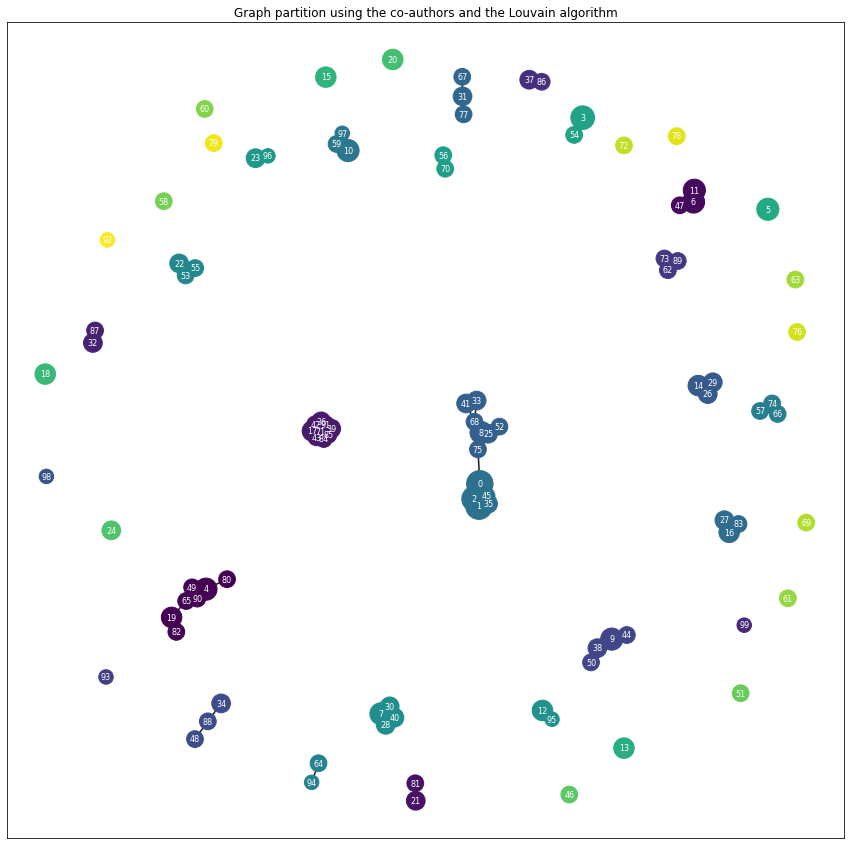

{0: 'Bennett DA',
 1: 'Wilson RS',
 2: 'Bienias JL',
 3: 'Harvey PD',
 4: 'Robbins TW',
 5: 'Green MF',
 6: 'Deary IJ',
 7: 'Mathan S',
 8: 'Kuller LH',
 9: 'Kumari V',
 10: 'Milgram NW',
 11: 'Starr JM',
 12: 'Stip E',
 13: 'Jolles J',
 14: 'Bell MD',
 15: '[Anonymous]',
 16: 'De Haan EHF',
 17: 'Fox GB',
 18: 'Grafman J',
 19: 'Sahakian BJ',
 20: 'Wolf OT',
 21: 'Terry AV',
 22: 'Yang X',
 23: 'Wolf PA',
 24: 'Nomikos GG',
 25: 'Lopez OL',
 26: 'Wexler BE',
 27: 'Kappelle LJ',
 28: 'Whitlow SD',
 29: 'Bryson GJ',
 30: 'Ververs PM',
 31: 'Krystal JH',
 32: 'Banaji MR',
 33: 'Mungas D',
 34: 'London ED',
 35: 'Evans DA',
 36: 'Faghih R',
 37: 'Helmstaedter C',
 38: 'Sharma T',
 39: 'Hancock AA',
 40: 'Dorneich MC',
 41: 'Reed BR',
 42: 'Esbenshade TA',
 43: 'Pan JB',
 44: 'Frangou S',
 45: 'Schneider JA',
 46: 'Scheltens P',
 47: 'Whalley LJ',
 48: 'Leibenluft E',
 49: 'Barker RA',
 50: 'Barch DM',
 51: 'Russo MB',
 52: 'Fried LP',
 53: 'Wu AM',
 54: 'Reichenberg A',
 55: 'Xu D',
 56: 

In [12]:
def plot_cooc(in_dir, out_dir, item):
    
    '''Plots a cooccurrence graph. Saves the graph G to the Gephy .gexf standard
    '''
    # Standard library import
    from pathlib import Path
    
    # 3rd party import
    import BiblioAnalysis_Utils as bau
    
    # Internal import
    import networkx as nx

    G = bau.plot_graph(in_dir,item)
    nx.write_gexf(G,out_dir / Path('cooc_'+item+'.gexf'))
    
# "AU", "S", "I", "CU", "S2", "K", "AK", "TK", "R", "RJ"
in_dir = Path(r'C:\Users\franc\BiblioAnalysis_Files\Test_2005\freq')
out_dir = Path(r'C:\Users\franc\BiblioAnalysis_Files\Test_2005\freq')
item = 'AU'    
plot_cooc(in_dir, out_dir, item)